# Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium
!pip install gymnasium[box2d] gymnasium[mujoco] gymnasium[atari] gymnasium[accept-rom-license]
!pip install omegaconf hydra-core
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 42.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 46.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.3 M

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install mujoco==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.9 MB/s eta 0:00:00
  Using cached glfw-2.5.9-py2.py27.py3.py30.py31.py32.py33.py34.py35.py36.py37.py38-none-manylinux2014_x86_64.whl (207 kB)


In [ ]:
import time
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical

from omegaconf import OmegaConf

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
import gymnasium as gym
from gymnasium.experimental.wrappers import RecordVideoV0 as RecordVideo # warppers for making game video


# Requirements
- Selecting environments
- Implementing PPO

# 1. Select your environment

In [ ]:
# select your environment from the list
"""
environments list
classic control env_id list:  ["Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]
box2d env_id list:            ["LunarLander-v2", "BipedalWalker-v3"]
mujoco env_id list:           ["Swimmer-v4" , "Reacher-v4", "Hopper-v4", "Walker2d-v4", "Ant-v4", "HalfCheetah-v4", "HumanoidStandup-v4"]
atari env_id list:            ["BreakoutNoFrameskip-v4", "MsPacmanNoFrameskip-v4", "PongNoFrameskip-v4"] (optional. not recommended for no gpu device)
"""

env_id = "HumanoidStandup-v4"

In [ ]:
mujoco_env_id = ["Swimmer-v4" , "Reacher-v4", "Hopper-v4", "Walker2d-v4", "Ant-v4", "HalfCheetah-v4", "HumanoidStandup-v4"]

### 1.1 experiment config, path config

### Try to change the experiment configurations except `max_episode_steps`.

In [ ]:
exp_config = OmegaConf.create({
    "seed": 0,
    "num_envs": 4,
    "num_eval": 10,
    "max_episode_steps": 2048,
    "num_rollout_steps": 128,
    "num_minibatches": 4,
    "total_timesteps": 1000000,
    "print_interval": 100,
    "early_stop_wating_steps": 5000,
})

path_config = OmegaConf.create({
  "logs": Path("/content/drive/MyDrive/DATA403/runs"),
  "videos":Path("/content/drive/MyDrive/DATA403/videos"),
  "checkpoints": Path("/content/drive/MyDrive/DATA403/checkpoints"),
})


### 1.2 make_env function
For vectorized environments, we need a callable make_env function.

In [ ]:
def make_env(env_id, exp_config, path_config: OmegaConf, evaluation=False, idx=0):
    video_path = Path(path_config.videos)
    def thunk():
        env = gym.make(env_id, render_mode="rgb_array")
        if evaluation:
            test_path = Path(f"{env_id}/test")
            video_save_path = str(video_path / test_path)
        else:
            train_path = Path(f"{env_id}/train")
            video_save_path = str(video_path / train_path)
        # if idx==0:
        #     env = RecordVideo(env, video_save_path, disable_logger=True)
        # env = gym.wrappers.FlattenObservation(env)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if env_id in mujoco_env_id:
            env = gym.wrappers.TimeLimit(env, exp_config.max_episode_steps)
        # env = gym.wrappers.ClipAction(env)
        # env = gym.wrappers.NormalizeObservation(env)
        # env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
        return env
    return thunk

In [ ]:
make_env(env_id, exp_config, path_config) # the return of make_env is callable function

<function __main__.make_env.<locals>.thunk()>

In [ ]:
env = make_env(env_id, exp_config, path_config)() # <- Note that () is call action

In [ ]:
# Vectorized environments for fast training
# https://gymnasium.farama.org/api/vector/
envs = gym.vector.SyncVectorEnv(make_env(env_id, exp_config, path_config, evaluation=False, idx=idx)
                                for idx in range(exp_config.num_envs))


### Note that whether the environment is discrete or continuous
`gymnasium.spaces.Box`: continuous space
`gynmasium.spaces.Discrete`: discrete space


In [ ]:
print(env.observation_space)
print(env.action_space)


Box(-inf, inf, (376,), float64)
Box(-0.4, 0.4, (17,), float32)


# 2. make configurations
- environment
- ppo hyperparameters


### 2.1 make environment config
This configuration store the information of environment to build the neural network

In [ ]:
from gymnasium.spaces import Discrete, Box

def make_env_config(envs):
    env = envs.envs[0]
    print(env.observation_space)
    print(env.action_space)

    # * observation information
    if isinstance(env.observation_space, Discrete): # if observation_space is discrete
        state_dim = env.observation_space.n

    else:  # if observation_space is continuous
        if len(env.observation_space.shape) > 1: # Atari visual observation case
            state_dim = env.observation_space.shape
        else: # 1D vector observation case (classic control, box2d, mujoco)
            state_dim = env.observation_space.shape[0]

    # * action_space information
    num_discretes = 0
    if isinstance(env.action_space, Box):
        action_dim = env.action_space.shape[0]
        is_continuous = True
    elif isinstance(env.action_space, Discrete):
        action_dim = 1
        num_discretes = env.action_space.n
        is_continuous = False
    env_config = OmegaConf.create({"state_dim": state_dim,
                    "action_dim": int(action_dim),
                    "num_discretes": int(num_discretes),
                    "is_continuous": is_continuous})
    return env_config


In [ ]:
env_config = make_env_config(envs)
env_config

Box(-inf, inf, (376,), float64)
Box(-0.4, 0.4, (17,), float32)


{'state_dim': 376, 'action_dim': 17, 'num_discretes': 0, 'is_continuous': True}

### 2.2 ppo config
This configuration store the information of hyperparameters for training

### Try to change the ppo configurations depending on selected environment

In [ ]:
ppo_config = OmegaConf.create({
    "anneal_lr": True,
    "update_epochs": 10,
    "minibatch_size": 64,
    "lr": 3e-4,
    "max_grad_norm": 2.0,
    "norm_adv": True,
    "clip_coef": 0.2,
    "ent_coef": 0.1,
    "vf_coef": 0.5,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    })
print(ppo_config)
print(ppo_config.minibatch_size)


{'anneal_lr': True, 'update_epochs': 10, 'minibatch_size': 64, 'lr': 2e-05, 'max_grad_norm': 0.5, 'norm_adv': True, 'clip_coef': 0.2, 'ent_coef': 0.001, 'vf_coef': 0.5, 'gamma': 0.99, 'gae_lambda': 0.95}
64


# 3. Implementing PPO

You should do the following to implement PPO.
- Complete the ActorCritic class
- Implement the generalized advatage calculation part
- Implement the PPO loss and Value loss calculation part

### 3.1 ActorCritic Class

### You can create a neural network as you want to implement it.

In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorCritic(nn.Module):
    def __init__(self, env_config):
        super().__init__()
        self.state_dim = env_config["state_dim"]
        self.action_dim = env_config["action_dim"]
        self.num_discretes = env_config["num_discretes"]
        self.is_continuous = env_config["is_continuous"]

        ###################### Implement here : 1. Neural Network ########################
        self.critic = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        if self.is_continuous:
            self.actor_mean = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.action_dim),
            nn.Tanh()
        )
            self.actor_logstd = nn.Parameter(torch.zeros(1, self.action_dim))

        else:
            self.actor_logit = nn.Sequential(
                nn.Linear(self.state_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, self.action_dim),
                nn.Softmax(dim=-1)
            )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        ###################### Implement here : policy distribution ########################
        if self.is_continuous:
            action_mean = self.actor_mean(x)
            action_logstd = self.actor_logstd.expand_as(action_mean)
            action_std = torch.exp(action_logstd)
            probs = torch.distributions.Normal(action_mean, action_std) # Use torch distribution Noraml
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action).sum(-1), probs.entropy().sum(-1), self.critic(x)
        else:
            logits = self.actor_logit(x)
            probs = torch.distributions.Categorical(logits=logits) # Use torch distribution Categorical
            if action is None:
                action = probs.sample()
            return action, probs.log_prob(action), probs.entropy(), self.critic(x)


def save_model(env_id, path_cfg, actor_critic, update):
    ckpt_path = Path(path_cfg.checkpoints) / Path(f"{env_id}")
    if not ckpt_path.exists():
        ckpt_path.mkdir()
    model_name = Path(f"PPO_{update}.pt")
    model_path = ckpt_path / model_name
    torch.save(actor_critic.state_dict(), str(model_path))
    print(f"model saved to {model_path}")

In [ ]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_param(ActorCritic(env_config))
print('Number of parameters for ActorCritic: {:}'.format(num_params))

Number of parameters for ActorCritic: 280099


In [ ]:
from dataclasses import dataclass
from typing import List

@dataclass
class GlobalLogger:
    global_steps: List
    save_update_steps: List
    episodic_return_steps: List
    train_episodic_return: List
    test_episodic_return: List
    policy_loss: List
    value_loss: List
    entropy_loss: List

## 3.2 train

### Implement the GAE calculation part and ppo loss, value loss part by referring the pictures.

### GAE: https://arxiv.org/abs/1506.02438


### PPO: https://arxiv.org/abs/1707.06347



### GAE calculation

![](GAE_calculation.png)

#### PPO Clipped loss

![](PPO_loss.png)

### You can refer to any open source code and complete it.
GAE references:
- https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737
- https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/

PPO references:
- https://spinningup.openai.com/en/latest/algorithms/ppo.html

In [ ]:
from torch.utils.tensorboard import SummaryWriter

global_logger = GlobalLogger(
                            global_steps = [],
                            save_update_steps = [],
                            episodic_return_steps = [],
                            train_episodic_return=[],
                            test_episodic_return=[],
                            policy_loss=[],
                            value_loss=[],
                            entropy_loss=[]
                            )

# Set minibatch_size
# tensorboard writer, global_recorder
log_path = str(Path(path_config.logs) / Path(env_id))
writer = SummaryWriter(log_path)
global_logger.log_path = log_path

# Managing seed for reproducible experiments
random.seed(exp_config.seed)
np.random.seed(exp_config.seed)
torch.manual_seed(exp_config.seed)

In [ ]:
from IPython.display import clear_output

# Set device and make environment
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
envs = gym.vector.SyncVectorEnv(make_env(env_id, exp_config, path_config, evaluation=False, idx=idx)
                                for idx in range(exp_config.num_envs))

# Initialize agent and optimizer
agent = ActorCritic(env_config).to(device)
optimizer = optim.Adam(agent.parameters(), lr=ppo_config.lr, eps=1e-5)

# ALGO Logic: On Policy Storage setup
obs = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
rewards = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
dones = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)
values = torch.zeros((exp_config.num_rollout_steps, exp_config.num_envs)).to(device)


global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=exp_config.seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(exp_config.num_envs).to(device)
num_updates = exp_config.total_timesteps // exp_config.num_rollout_steps # number of epochs

save_positions = np.arange(0, num_updates//10 + num_updates, num_updates//10)
total_loss = 0

for update in range(0, num_updates + 1):
    # Annealing the rate if instructed to do so.
    if ppo_config.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * ppo_config.lr
        optimizer.param_groups[0]["lr"] = lrnow if lrnow > 1e-5 else 1e-5

    # ! rollout multiple environments
    for step in range(0, exp_config.num_rollout_steps):
        global_step += 1 * exp_config.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        next_obs, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue
        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            if global_step % 10 == 0:
                print(f"num_updates: {update}/{num_updates}, global_step={global_step}, episodic_return={info['episode']['r']}, total_loss={total_loss}")
            writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
            writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
            global_logger.train_episodic_return.append(info["episode"]["r"])
            global_logger.episodic_return_steps.append(global_step)

    # Save model
    if update in save_positions:
        global_logger.save_update_steps.append(update)
        save_model(env_id, path_config, agent, update)

    global_logger.global_steps.append(global_step)

    # ! bootstrap value if not done
    ###################### Implement here : 2. Generalized Advantage Estimation ########################
    # GAE part. Refer the GAE calculation picture

    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros(len(rewards)+1, exp_config.num_envs).to(device)
        for t in reversed(range(exp_config.num_rollout_steps)):
            if t == exp_config.num_rollout_steps - 1:
                done_mask = 1.0 - next_done
                nextvalues = next_value
            else:
                done_mask = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + (ppo_config.gamma * nextvalues * done_mask) - values[t]
            advantages[t] = delta + (ppo_config.gamma * ppo_config.gae_lambda * advantages[t + 1] * done_mask)

        returns = advantages[:-1] + values

    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # ! Optimizing the policy and value network
    agent.train()
    batch_size = exp_config.num_rollout_steps * exp_config.num_envs
    mb_size = ppo_config.minibatch_size
    b_inds = np.arange(batch_size) # batch_size = num_rollout_steps
    for epoch in range(ppo_config.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, mb_size):
            end = start + mb_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            mb_advantages = b_advantages[mb_inds]
            if ppo_config.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            ###################### Implement here : 3. PPO Loss, Value Loss ########################
            # Be careful about pytorch automatic broadcasting.
            # Policy loss part. Refer the PPO clip loss picture
            pg_loss1 = ratio * mb_advantages
            pg_loss2 = torch.clamp(ratio, 1 - ppo_config.clip_coef, 1 + ppo_config.clip_coef) * mb_advantages
            pg_loss = torch.min(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            v_loss = nn.SmoothL1Loss()(newvalue, b_returns[mb_inds])

            entropy_loss = entropy.mean()

            ###################### Implement here : 4. Total Loss ########################
            # implement the total loss value by using the coefficients in ppo_config
            total_loss = -pg_loss + ppo_config.vf_coef * v_loss - ppo_config.ent_coef * entropy_loss
            optimizer.zero_grad()
            total_loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), ppo_config.max_grad_norm)
            optimizer.step()

    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
    global_logger.value_loss.append(v_loss.item())
    global_logger.policy_loss.append(pg_loss.item())
    global_logger.entropy_loss.append(entropy_loss.item())

    if update % 100 == 0:
        clear_output()

envs.close()
writer.close()
print("Training is finished...")



num_updates: 7804/7812, global_step=3996000, episodic_return=[154368.39], total_loss=20.027881622314453
num_updates: 7804/7812, global_step=3996000, episodic_return=[148126.53], total_loss=20.027881622314453
num_updates: 7804/7812, global_step=3996000, episodic_return=[156392.39], total_loss=20.027881622314453
num_updates: 7804/7812, global_step=3996000, episodic_return=[157656.31], total_loss=20.027881622314453
model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/PPO_7810.pt
num_updates: 7812/7812, global_step=4000000, episodic_return=[157583.14], total_loss=18.214641571044922
num_updates: 7812/7812, global_step=4000000, episodic_return=[158386.48], total_loss=18.214641571044922
num_updates: 7812/7812, global_step=4000000, episodic_return=[156466.05], total_loss=18.214641571044922
num_updates: 7812/7812, global_step=4000000, episodic_return=[156210.56], total_loss=18.214641571044922
Training is finished...


In [ ]:
save_model(env_id, path_config, agent, update)

model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/PPO_7812.pt


# Visualization of results

In [ ]:
x = np.array(global_logger.episodic_return_steps)
y = np.array(global_logger.train_episodic_return).squeeze(1)
print(x.shape)
print(y.shape)

(4000,)
(4000,)


figure is saved to /content/drive/MyDrive/DATA403/runs/HumanoidStandup-v4/train_episodic_return.jpg


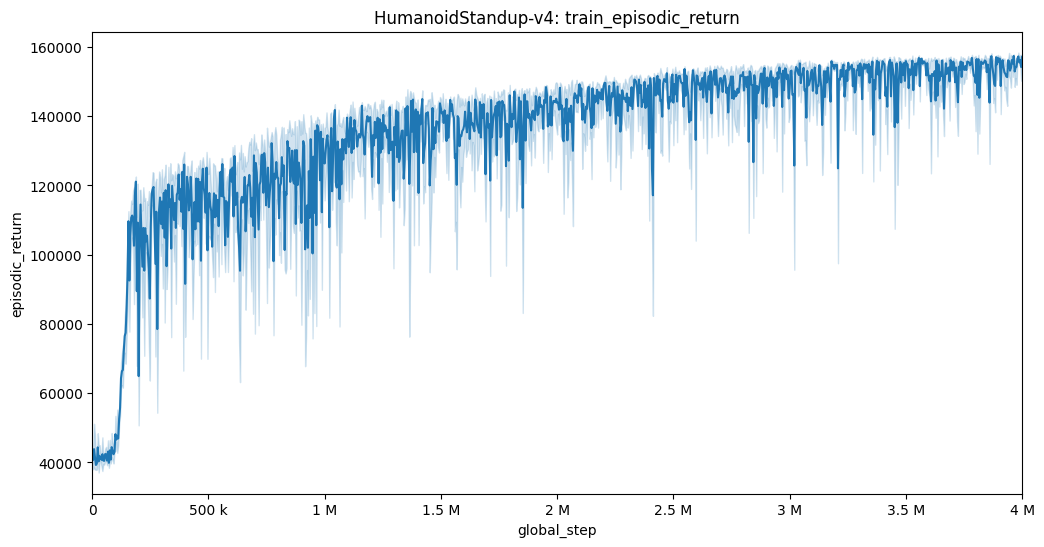

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style('darkgrid')
sns.set_context("poster")
sns.set(font_scale=1)
g = sns.lineplot(x=x, y=y).set(title=f'{env_id}: train_episodic_return')
global_logger.global_steps
ax.set(xlim = (0,global_logger.global_steps[-1]))
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.set(xlabel='global_step', ylabel='episodic_return')
save_path = Path(global_logger.log_path)
file_name =  Path("train_episodic_return.jpg")
file_path = save_path / file_name
print(f"figure is saved to {str(file_path)}")
plt.savefig(str(file_path), dpi = 200)

In [ ]:
def evaluate(env_id, exp_config, path_config, env_config, ppo_config, global_logger):
    envs = gym.vector.SyncVectorEnv(
             [make_env(env_id, exp_config, path_config, evaluation=True, idx=0)]
            )
    device = torch.device("cpu")
    agent = ActorCritic(env_config).to(device)
    ckpt_path = Path(path_config.checkpoints) / Path(env_id)
    file_name = Path(f"PPO_3905.pt")
    file_path = str(ckpt_path / file_name)
    agent.load_state_dict(torch.load(file_path, map_location=device))
    agent.eval()
    print("Loading model is successful")

    next_obs, _ = envs.reset()
    next_obs = torch.Tensor(next_obs).to(device)
    next_done = torch.zeros(1).to(device)
    episodic_returns = []
    while len(episodic_returns) < exp_config.num_eval:
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
        next_obs, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)
        # Only print when at least 1 env is done
        if "final_info" not in infos:
            continue
        for info in infos["final_info"]:
            # Skip the envs that are not done
            if info is None:
                continue
            print(f"test_episodic_return={info['episode']['r']}")
            episodic_returns.append(info['episode']['r'])
    global_logger.test_episodic_return = episodic_returns

In [ ]:
evaluate(env_id, exp_config, path_config, env_config, ppo_config, global_logger)

Loading model is successful
test_episodic_return=[124337.36]
test_episodic_return=[120676.92]
test_episodic_return=[135824.52]
test_episodic_return=[135058.7]
test_episodic_return=[109403.67]
test_episodic_return=[131945.1]
test_episodic_return=[135888.05]
test_episodic_return=[137421.38]
test_episodic_return=[137867.44]
test_episodic_return=[138599.31]


In [ ]:
y = np.array(global_logger.test_episodic_return)
y = y.squeeze(1)
print(y)
print(y.mean())

[ 40157.055 126121.4   127258.914 133603.75  128214.54  130087.32
 132528.83  133327.61  135695.86  136518.92 ]
122351.414


figure is saved to /content/drive/MyDrive/DATA403/runs/HumanoidStandup-v4/test_episodic_return.jpg


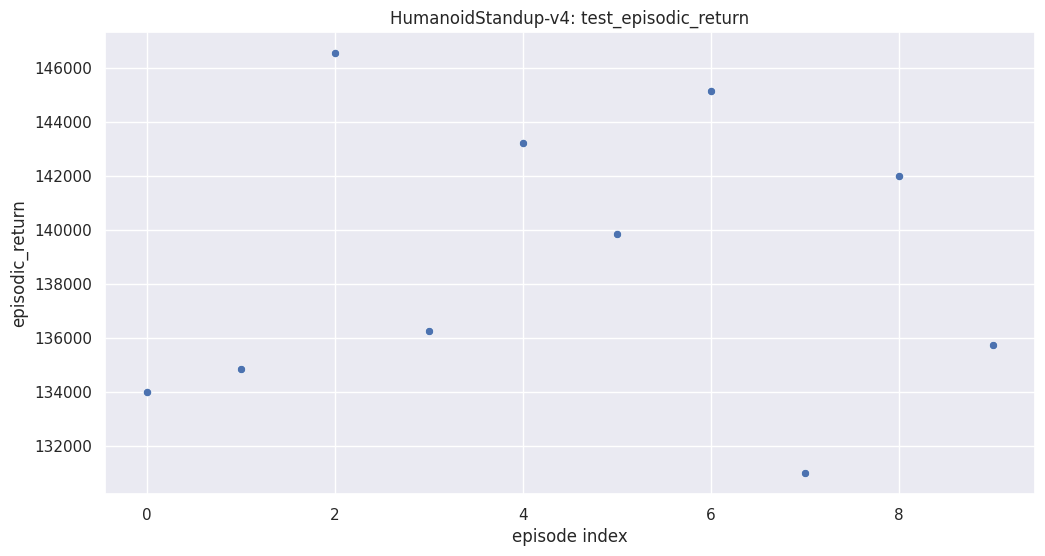

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel='episode index', ylabel='episodic_return')
sns.set_style('darkgrid')
sns.set_context("poster")
sns.set(font_scale=1)
g = sns.scatterplot(x=range(len(y)), y=y).set(title=f'{env_id}: test_episodic_return')
save_path = Path(global_logger.log_path)
file_name =  Path("test_episodic_return.jpg")
file_path = save_path / file_name
print(f"figure is saved to {str(file_path)}")
plt.savefig(str(file_path), dpi = 200)

# SAC

In [ ]:
import copy
import random
import collections
import math

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim


from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from gymnasium.experimental.wrappers import RecordVideoV0 as RecordVideo


In [ ]:
sac_config = OmegaConf.create({
    # replay memory
    'buffer_limit': int(1e6),
    'batch_size': 256,

    # neural network parameters
    'device': 'cuda:0',
    'hidden_dim': 256,
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]), # cannot use .n because not actions are continuous!

    # learning parameters
    'gamma': 0.99,
    'target_entropy': -17
    'tau': 0.005,
    'init_alpha': 0.01,
    'lr_pi': 3e-4,
    'lr_q': 3e-4,
    'lr_alpha': 3e-4
})

In [ ]:
class ReplayBuffer():
    def __init__(self, config):
        self.buffer = collections.deque(maxlen=sac_config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            s_prime_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)

    def size(self):
        return len(self.buffer)

In [ ]:
import torch.nn.init as init

def weights_init_xavier(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, config):
        super(PolicyNet, self).__init__()
        self.config = config
        self.fc1 = nn.Linear(config.state_dim, config.hidden_dim)
        self.fc_mu = nn.Linear(config.hidden_dim,config.action_dim)
        self.fc_std  = nn.Linear(config.hidden_dim,config.action_dim)
        self.optimizer = optim.Adam(self.parameters(), lr=config.lr_pi)

        self.log_alpha = torch.tensor(np.log(config.init_alpha))
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=config.lr_alpha)

        # self.apply(weights_init_xavier)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        std = torch.clamp(std, min=math.exp(-20), max=math.exp(2))
        dist = Normal(mu, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        real_action = torch.tanh(action)
        real_log_prob = log_prob - torch.log(1 - real_action.pow(2) + 1e-6)
        return real_action, real_log_prob

    def train_net(self, q1, q2, mini_batch):
        s, _, _, _, _ = mini_batch
        a, log_prob = self.forward(s)
        entropy = -self.log_alpha.exp() * log_prob

        q1_val, q2_val = q1(s,a), q2(s,a)
        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]

        loss = -min_q - entropy # for gradient ascent
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.config.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()


class QNet(nn.Module):
    def __init__(self, config):
        super(QNet, self).__init__()
        self.config = config
        self.fc_s = nn.Linear(config.state_dim, config.hidden_dim)
        self.fc_a = nn.Linear(config.action_dim,config.hidden_dim)
        self.fc_cat = nn.Linear(config.hidden_dim*2,config.hidden_dim)
        self.fc_out = nn.Linear(config.hidden_dim,1)
        self.optimizer = optim.Adam(self.parameters(), lr=config.lr_q)

        # self.apply(weights_init_xavier)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_cat(cat))
        q = self.fc_out(q)
        return q

    def train_net(self, target, mini_batch):
        s, a, r, s_prime, done = mini_batch
        value = self.forward(s, a)
        # print(f"value_shape: {value.shape}")

        loss = F.smooth_l1_loss(value, target)
        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def soft_update(self, net_target):
        for param_target, param in zip(net_target.parameters(), self.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.config.tau) + param.data * self.config.tau)

In [ ]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params1 = count_param(PolicyNet(sac_config))
num_params2 = count_param(QNet(sac_config))
print('Number of parameters for PolicyNet: {:}, Number of parameters for QNet: {:}'.format(num_params1, num_params2))

Number of parameters for PolicyNet: 105250, Number of parameters for QNet: 232705


In [ ]:
def calc_target(pi, q1, q2, mini_batch):
    s, a, r, s_prime, done = mini_batch
    s = s.to(sac_config.device)
    a = a.to(sac_config.device)
    r = r.to(sac_config.device)
    s_prime = s_prime.to(sac_config.device)
    done = done.to(sac_config.device)

    with torch.no_grad():
        a_prime, log_prob = pi(s_prime)
        entropy = -pi.log_alpha.exp() * log_prob
        q1_val, q2_val = q1(s_prime,a_prime).to(sac_config.device), q2(s_prime,a_prime).to(sac_config.device)
        # print(f"q1_val shape: {q1_val.shape}")
        # print(f"q2_val shape: {q2_val.shape}")

        q1_q2 = torch.cat([q1_val, q2_val], dim=1)
        min_q = torch.min(q1_q2, 1, keepdim=True)[0]
        target = r + sac_config.gamma * done * (min_q + entropy.mean())
        # print(f"target_shape: {target.shape}")
    return target

In [ ]:
num_epis, epi_rews = 2000, []
memory = ReplayBuffer(sac_config)
q1, q2, q1_target, q2_target = \
    QNet(sac_config).to(sac_config.device), QNet(sac_config).to(sac_config.device), QNet(sac_config).to(sac_config.device), QNet(sac_config).to(sac_config.device)
pi = PolicyNet(sac_config).to(sac_config.device)

q1_target.load_state_dict(q1.state_dict())
q2_target.load_state_dict(q2.state_dict())

device = sac_config.device

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0

    while not (terminated or truncated):
        state = torch.tensor(state, dtype=torch.float32).to(device)

        action, log_prob = pi(state)
        action = action.cpu().detach().numpy()

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.from_numpy(next_state).to(device)
        reward = torch.from_numpy(np.array(reward)).float().to(device)
        terminated = torch.from_numpy(np.array(terminated)).to(device)
        truncated = torch.from_numpy(np.array(truncated)).to(device)

        # save transition to replay buffer
        done = terminated or truncated
        memory.put((state, action, reward, next_state, done))

        # state transition
        state = next_state

        # record reward
        epi_rew += reward

        if done:
            print(f"\tn_epi total_reward: {epi_rew}")

    # enough memory
    if memory.size() > sac_config.buffer_limit:
        for i in range(20):
            mini_batch = memory.sample(sac_config.batch_size)
            state, action, reward, next_state, done = mini_batch

            state = state.to(device)
            action = action.to(device)
            reward = reward.to(device)
            next_state = next_state.to(device)
            done = done.to(device)

            td_target = calc_target(pi, q1_target, q2_target, (state, action, reward, next_state, done))
            q1.train_net(td_target, (state, action, reward, next_state, done))
            q2.train_net(td_target, (state, action, reward, next_state, done))
            entropy = pi.train_net(q1, q2, (state, action, reward, next_state, done))
            q1.soft_update(q1_target)
            q2.soft_update(q2_target)

    epi_rews.append(epi_rew)

env.close()

In [ ]:
plt.figure(figsize=(20, 10), dpi=300)
epi_rews = [epi.detach().cpu().numpy() for epi in epi_rews]
plt.plot(epi_rews[:1000], label='episode returns')
plt.legend(fontsize=20)
plt.show()
plt.close()

In [ ]:
ckpt_path = Path(path_config.checkpoints) / Path(f"{env_id}")
if not ckpt_path.exists():
    ckpt_path.mkdir()

model_name = Path(f"SAC_{n_epi}_q1.pt")
model_path = ckpt_path / model_name
torch.save(q1.state_dict(), str(model_path))
print(f"model saved to {model_path}")

model_name = Path(f"SAC_{n_epi}_q2.pt")
model_path = ckpt_path / model_name
torch.save(q2.state_dict(), str(model_path))
print(f"model saved to {model_path}")

model_name = Path(f"SAC_{n_epi}_q1_target.pt")
model_path = ckpt_path / model_name
torch.save(q1_target.state_dict(), str(model_path))
print(f"model saved to {model_path}")

model_name = Path(f"SAC_{n_epi}_q2_target.pt")
model_path = ckpt_path / model_name
torch.save(q2_target.state_dict(), str(model_path))
print(f"model saved to {model_path}")

model_name = Path(f"SAC_{n_epi}_pi.pt")
model_path = ckpt_path / model_name
torch.save(pi.state_dict(), str(model_path))
print(f"model saved to {model_path}")

model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/SAC_1105_q1.pt
model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/SAC_1105_q2.pt
model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/SAC_1105_q1_target.pt
model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/SAC_1105_q2_target.pt
model saved to /content/drive/MyDrive/DATA403/checkpoints/HumanoidStandup-v4/SAC_1105_pi.pt
